In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from math import *

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import usaddress

import pickle

# Ouverture et analyses de base

In [2]:
data = pd.read_csv('./data/2016_Building_Energy_Benchmarking.csv')

In [3]:
data.head(15)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.529300,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.816410,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.000000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.130860,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.984380,8803998.0,False,NaN,Compliant,NaN,505.01,2.88
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.0,0660000560,...,2.160444e+06,7371434.0,47151.816410,4715182.0,False,NaN,Compliant,NaN,301.81,3.10
6,10,2016,NonResidential,Hotel,Camlin,1619 9th Avenue,Seattle,WA,98101.0,0660000825,...,8.239199e+05,2811215.0,29475.800780,2947580.0,False,NaN,Compliant,NaN,176.14,2.12
7,11,2016,NonResidential,Other,Paramount Theatre,911 Pine St,Seattle,WA,98101.0,0660000955,...,1.065843e+06,3636655.0,3851.890137,385189.0,False,NaN,Compliant,NaN,221.51,2.16
8,12,2016,NonResidential,Hotel,311wh-Pioneer Square,612 2nd Ave,Seattle,WA,98104.0,0939000080,...,2.138898e+06,7297919.0,64259.000000,6425900.0,False,NaN,Compliant,NaN,392.16,2.39
9,13,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Lyon Building,607 - 3rd Ave.,Seattle,WA,98104.0,0939000105,...,7.420912e+05,2532015.0,10020.259770,1002026.0,False,NaN,Compliant,NaN,151.12,2.37


In [4]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (3376, 46) :



Type des colonnes :
|                                 | 0       |
|:--------------------------------|:--------|
| OSEBuildingID                   | int64   |
| DataYear                        | int64   |
| BuildingType                    | object  |
| PrimaryPropertyType             | object  |
| PropertyName                    | object  |
| Address                         | object  |
| City                            | object  |
| State                           | object  |
| ZipCode                         | float64 |
| TaxParcelIdentificationNumber   | object  |
| CouncilDistrictCode             | int64   |
| Neighborhood                    | object  |
| Latitude                        | float64 |
| Longitude                       | float64 |
| YearBuilt                       | int64   |
| NumberofBuildings               | float64 |
| NumberofFloors                  | int64   |
| PropertyGFATotal                | int64   |
| PropertyGFAParking   

<AxesSubplot: >

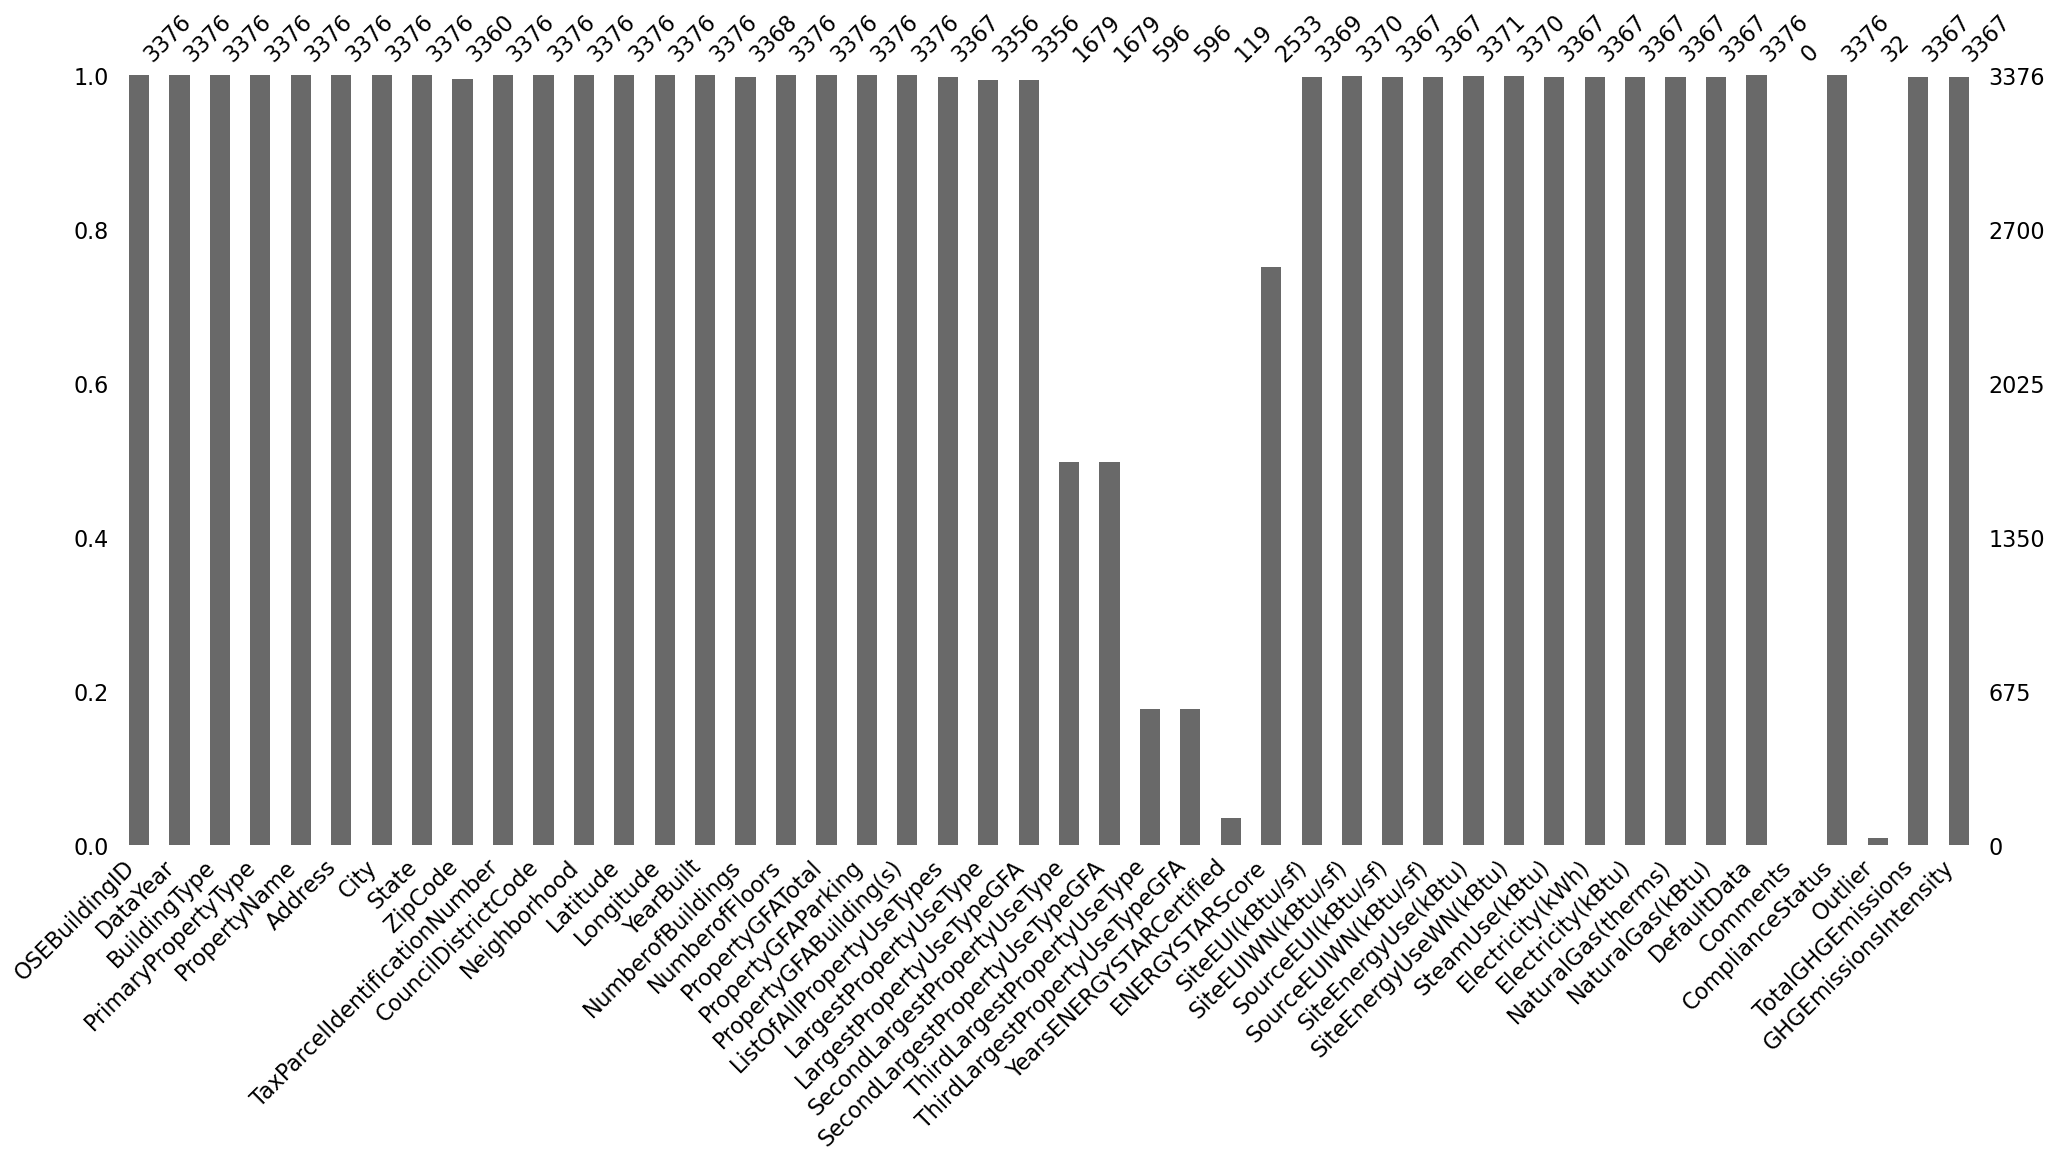

In [5]:
msno.bar(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


### Descriptions interactives

In [8]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [9]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [10]:
@interact
def show_extract(column=list(data.columns)):
    tmp = data[column].value_counts()
    print(len(tmp))
    return data[column].value_counts().iloc[:20]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

# On ne garde que les Non Residential

In [11]:
data = data.drop(data[~data['BuildingType'].str.lower().str.contains('nonresidential')].index).copy()

# On ne garde que les "Compliance"

In [12]:
data = data.drop(data[data['ComplianceStatus'] != 'Compliant'].index).copy()

# Mise en forme du dataset

In [13]:
t = ('int64', 'discrete', 'continue', 'nominal', 'ordinal')

In [14]:
for c in ['ZipCode', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 
          'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']:
    data[c] = data[c].astype('int64', errors='ignore')

In [15]:
COL = {'OSEBuildingID': ('string', 'nominal'),
       'DataYear':('int64', 'discrete'),
       'BuildingType':('category', ('string', 'nominal')),
       'PrimaryPropertyType':('category', ('string', 'nominal')),
       'PropertyName':('string', 'nominal'),
       'Address':('string', 'nominal'),
       'City':('category', ('string', 'nominal')),
       'State':('category', ('string', 'nominal')),
       'ZipCode':('category', ('string', 'nominal')),
       'TaxParcelIdentificationNumber':('string', 'nominal'),
       'CouncilDistrictCode':('category', ('string', 'nominal')),
       'Neighborhood':('category', ('string', 'nominal')),
       'Latitude':('float32', 'continue'),
       'Longitude':('float32', 'continue'),
       'YearBuilt':('int64', 'discrete'),
       'NumberofBuildings':('int64', 'discrete'),
       'NumberofFloors':('int64', 'discrete'),
       'PropertyGFATotal':('int64', 'discrete'),
       'PropertyGFAParking':('int64', 'discrete'),
       'PropertyGFABuilding(s)':('int64', 'discrete'),
       'ListOfAllPropertyUseTypes':('category', ('string', 'nominal')),
       'LargestPropertyUseType':('category', ('string', 'nominal')),
       'LargestPropertyUseTypeGFA':('int64', 'discrete'),
       'SecondLargestPropertyUseType':('category', ('string', 'nominal')),
       'SecondLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'ThirdLargestPropertyUseType':('category', ('string', 'nominal')),
       'ThirdLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'YearsENERGYSTARCertified':('string', 'nominal'),
       'ENERGYSTARScore':('float32', 'continue'),
       'SiteEUI(kBtu/sf)':('float32', 'continue'),
       'SiteEUIWN(kBtu/sf)':('float32', 'continue'),
       'SourceEUI(kBtu/sf)':('float32', 'continue'),
       'SourceEUIWN(kBtu/sf)':('float32', 'continue'),
       'SiteEnergyUse(kBtu)':('float32', 'continue'),
       'SiteEnergyUseWN(kBtu)':('float32', 'continue'),
       'SteamUse(kBtu)':('float32', 'continue'),
       'Electricity(kWh)':('float32', 'continue'),
       'Electricity(kBtu)':('float32', 'continue'),
       'NaturalGas(therms)':('float32', 'continue'),
       'NaturalGas(kBtu)':('float32', 'continue'),
       'DefaultData':('boolean', 'nominal'),
       'Comments':('string', 'nominal'),
       'ComplianceStatus':('category', ('string', 'nominal')),
       'Outlier':('category', ('string', 'nominal')),
       'TotalGHGEmissions':('float32', 'continue'),
       'GHGEmissionsIntensity':('float32', 'continue')}

## Formatage de toutes les colonnes
### Changement du type

In [16]:
for c, e in COL.items():
    t, o = e
    if t == 'category':
        t, o = o
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()
        data[c] = data[c].astype('category', errors='ignore')
    else:
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()

## Créations de listes utiles

In [17]:
# Liste des colonnes à prédire (et leur nouveau nom)
col_Y =  ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
col_Y_rename = ['Energy_Y', 'CO2_Y']

# Liste des colonnes à ne pas utiliser car faisant partie des relevés
col_interdit = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUseWN(kBtu)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', #'Outlier',
                'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments',
                'ComplianceStatus', 'GHGEmissionsIntensity', 'OSEBuildingID', 'TotalGHGEmissions']

for c in col_Y:
    col_interdit.remove(c)

col_inutile = ['DataYear', 'ListOfAllPropertyUseTypes', 'City', 'State', 'TaxParcelIdentificationNumber',
               'ListOfAllPropertyUseTypes', 'YearsENERGYSTARCertified']

In [18]:
if 'SiteEnergyUseWN(kBtu)' in col_Y:
    data = data.drop(data[data['SiteEnergyUseWN(kBtu)']  == 0].index).copy()

In [19]:
def update_col(data, out=True):
    global col_nan, col_autorise, col_num, col_cat, col_hot
    
    # Liste des colonnes avec plus de 50% de NaN
    col_nan = data.columns[data.isna().sum() > len(data)/2].to_list()

    # Inverse de la liste col_interdit et col_nan
    col_autorise = [e for e in data.columns if e not in col_interdit+col_nan+col_inutile]

    if out:
        #Ajout temperaire pour vérifier les outliers
        col_autorise += ['Outlier']

    # Liste des colonnes numeriques
    col_num = data[col_autorise].select_dtypes(include=['float', 'int']).columns.to_list()
    
    # Liste des colonnes venant de l'encodage one hot
    col_hot = data[col_autorise].select_dtypes(include=['uint8']).columns.to_list()

    # Liste des colonnes categorielles
    col_cat = data[col_autorise].select_dtypes(include=['category']).columns.to_list()

In [20]:
update_col(data)

## Modification des valeurs
### Gestion des outliers

In [21]:
# Affichage des outliers selon les quantilles

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col] > data[col].mean() + 3 * data[col].std(), col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [22]:
# Affichage des 5 valeurs les plus hautes

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col].sort_values(ascending=False).index[:5], col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [23]:
# Modification des erreurs
data.loc[data['OSEBuildingID']=='21611', 'NumberofFloors'] = 1

### Remplacement des NaN

In [24]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].cat.add_categories('').fillna('')
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].cat.add_categories('').fillna('')
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].cat.add_categories('').fillna('')

In [25]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna(0)
data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0)
data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0)

### Création de nouvelles colonnes

In [26]:
# Colonnes de présence de certaines energies (puis conversion numerique)
data[['Steam', 'Electricity', 'Gas']] = data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']] > 0
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].replace({True: 1, False: 0})
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].astype('int', errors='ignore')

In [27]:
# Fonction pour ne retourner qu'une partie de l'addresse (enleve le numero)
def extract_street(address):
    # Parser l'adresse
    parsed_address = usaddress.parse(address)
    
    street = ""
    
    # Boucle à travers les composants de l'adresse pour trouver la rue
    for component in parsed_address:
        #if 'StreetName' in component[1]:
        if component[1] in ['StreetName', 'StreetNamePostType']:
            street += ' ' + component[0]
    street = street.replace('.', '')[1:]
    return street

In [28]:
# Colonne d'adresse plus simple (sans position ou numero)
data['SimpleAddress'] = data['Address'].apply(extract_street)
data['SimpleAddress'] = data['SimpleAddress'].astype('string', errors='ignore').astype('category', errors='ignore')

In [29]:
# Nombre d'usages de la parcelle
data['NumberOfPropertyUseTypes'] = data['ListOfAllPropertyUseTypes'].str.count(',') + 1

In [30]:
# Volume interieur
data['VolumeInside'] = data['PropertyGFABuilding(s)'] * data['NumberofFloors']

In [31]:
# Age plutot qu'annee
data['Age'] = 2023 - data['YearBuilt']
col_inutile.append('YearBuilt')

In [32]:
# Proximité à l'équateur [0 pole nord, 1 equateur]
data['EquatorProximity'] = (90 - data['Latitude'].abs())/90

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [34]:
# Estimation de la distance à la mer de chaque batiment
with open('./data/dist_model.plk', 'rb') as f:
    neigh = pickle.load(f)

data['SeaProximity'] = neigh.predict(data[['Longitude', 'Latitude']])
# data['SeaProximityLog'] = data['SeaProximity'].apply(lambda x: log(x+1))

In [35]:
# Estimation de la distance à l'eau de chaque batiment
with open('./data/dist_model_limit.plk', 'rb') as f:
    neigh = pickle.load(f)

data['SeaProximityLimit'] = neigh.predict(data[['Longitude', 'Latitude']])
# data['SeaProximityLogLimit'] = data['SeaProximityLimit'].apply(lambda x: log(x+1))

In [36]:
# Fonction d'arrondi plus subtile qu'en base 10
def rond(v, arrondi):
    return int(v/arrondi)*arrondi

In [37]:
# Placement des coordonées sur une grille simplifie
grille = []
# Et liste servant à ordoner les coordonées
ordre_grille = []

for i, v in data[['Longitude', 'Latitude']].iterrows():
    x, y = rond(v[0], 0.05), rond(v[1], 0.05)
    coord = "({}, {})".format(x, y)
    grille.append(coord)
    ordre_grille.append([coord, x*y])

grille = pd.DataFrame(grille, index=data.index, columns=['LonLatGrille']).astype('string').astype('category')
ordre_grille = pd.DataFrame(ordre_grille, columns=['Coords', 'Val']).sort_values(by='Val').drop_duplicates()

print("Nombre de valeurs prises :", len(ordre_grille))

Nombre de valeurs prises : 18


In [38]:
# Ajout des coordonées sur grille au dataset
data = data.join(grille)
data['LonLatGrille'] = data['LonLatGrille'].astype('string').astype('category')

## Conversion des categories

In [39]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [40]:
update_col(data, out=False)

In [41]:
data[col_cat].isna().sum()

BuildingType                     0
PrimaryPropertyType              0
ZipCode                         13
CouncilDistrictCode              0
Neighborhood                     0
LargestPropertyUseType           0
SecondLargestPropertyUseType     0
ThirdLargestPropertyUseType      0
SimpleAddress                    0
LonLatGrille                     0
dtype: int64

### Correction des ZipCode

In [42]:
# data.loc[data['ZipCode'].isna(), ['OSEBuildingID', 'Address']]

In [43]:
# Correction mannuelle des zipcode manquants
fill_zipcode = [('50196', '98109'), ('50198', '98144'), ('50201', '98117'), ('50204', '98125'),
               ('50207', '98107'), ('50208', '98117'), ('50210', '98103'), ('50212', '98112'),
               ('50219', '98122'), ('50220', '98118'), ('50221', '98126'), ('50222', '98108'),
               ('50223', '98104'), ('50224', '98119'), ('50225', '98109'), ('50226', '98108')]

for i, z in fill_zipcode:
    if z not in data['ZipCode'].cat.categories:
        data['ZipCode'] = data['ZipCode'].cat.add_categories([z])
    
    data.loc[data['OSEBuildingID']==i, 'ZipCode'] = z

data['ZipCode'] = data['ZipCode'].cat.add_categories('0').fillna('0')

In [44]:
# Uniformisation des zipcode (certains ont des virgules et d'autres non)
data['ZipCode'] = data['ZipCode'].astype('string').apply(lambda x : int(float(x))).astype('string').astype('category')

In [45]:
data[col_cat].nunique()

BuildingType                      3
PrimaryPropertyType              21
ZipCode                          48
CouncilDistrictCode               7
Neighborhood                     14
LargestPropertyUseType           56
SecondLargestPropertyUseType     48
ThirdLargestPropertyUseType      39
SimpleAddress                   451
LonLatGrille                     18
dtype: int64

### Gestion avancée des PropertyUseType
Comme un OneHotEncoding, sauf qu'à la place du 1 on met la valeur GFA (et 1 si jamais elle est de 0)

In [46]:
# tmp = data['ListOfAllPropertyUseTypes'].str.replace(r'\(.+\)', '', regex=True).str.split(', ').explode().to_list()
# tmp += data[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'PrimaryPropertyType']].stack().to_list()
# tmp = pd.Series(tmp).str.capitalize()

In [47]:
# Correction d'une faute typo
for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'PrimaryPropertyType']:
    data[col] = data[col].str.replace(' / ', '/')

In [48]:
# Listage des PropertyUseType les plus présents et on enlève les moins représentés
list_unique_use = []
list_unique_use.append('Autre')

for i, v in data[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'PrimaryPropertyType']].stack().value_counts().items():
    #print(i, v)
    if i != '' and v > 12:
        list_unique_use.append(i)
        
print('Nombre de use type gardés :', len(list_unique_use))

Nombre de use type gardés : 34


In [49]:
import seaborn as sns

In [50]:
sns.set(rc={"figure.figsize":(10, 20)})

In [51]:
@interact
def show_boxplot(col_reduit=['LargestPropertyUseType', 'SecondLargestPropertyUseType', 
                             'ThirdLargestPropertyUseType', 'PrimaryPropertyType'],
                 Y=['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']):
    sns.violinplot(data=data, x=Y, y=col_reduit, orient='h', scale='width', cut=0)

interactive(children=(Dropdown(description='col_reduit', options=('LargestPropertyUseType', 'SecondLargestProp…

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [53]:
for col_reduit in ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:

    #neigh = KNeighborsClassifier(n_neighbors=10, weights='distance')
    neigh = RandomForestClassifier(max_depth=50)

    mask = data[col_reduit].isin(list_unique_use)

    data_tmp = data.copy()
    data_tmp[col_cat] = OrdinalEncoder().fit_transform(data_tmp[col_cat])
    data_tmp[col_reduit] = data[col_reduit].copy()

    col = col_num + col_cat
    col.remove(col_reduit)
    col.remove('ENERGYSTARScore')
    for c in col_Y:
        if c in col:
            col.remove(c)
    neigh.fit(data_tmp.loc[mask, col].fillna(0), data_tmp.loc[mask, col_reduit].fillna(0))
    
    nb_avant = len(data[col_reduit].unique())
    
    if (~mask).sum() > 0:
        old = data_tmp.loc[~mask, col_reduit].copy()
        new = pd.Series(neigh.predict(data_tmp.loc[~mask, col].fillna(0)), index=old.index)

        final = pd.concat([old, new], axis=1)
        
        final = final.groupby(col_reduit).agg(lambda x:x.value_counts().index[0])
        final_dict = {}
        for i, n in final.iterrows():
            final_dict[i] = n[0]
        
        #print(final_dict)
        
        data.loc[~mask, col_reduit] = data.loc[~mask, col_reduit].apply(lambda x: final_dict[x] if x in final_dict else x)
        #data.loc[~mask, col_reduit] = neigh.predict(data_tmp.loc[~mask, col].fillna(0))
    
    print("{} passe de {} valeurs unique à {}".format(col_reduit, nb_avant, len(data[col_reduit].unique())))

PrimaryPropertyType passe de 21 valeurs unique à 19
LargestPropertyUseType passe de 56 valeurs unique à 26
SecondLargestPropertyUseType passe de 48 valeurs unique à 26
ThirdLargestPropertyUseType passe de 39 valeurs unique à 24


In [54]:
# Remplissage des colonnes
df_type = np.zeros((len(data), len(list_unique_use)))
col_data = data.columns.to_list()

for i in range(len(data)):
    for j in ['PrimaryPropertyType']:
        col = data.iloc[i, col_data.index(j)]
        col = col if col in list_unique_use else 'Autre'
        val = data.iloc[i, col_data.index('PropertyGFABuilding(s)')]
        #val = 1
        
        df_type[i][list_unique_use.index(col)] = val
    
    for j in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
        col = data.iloc[i, col_data.index(j)]
        val = data.iloc[i, col_data.index(j+'GFA')]
        #val = 1
        
        if col in list_unique_use:
            df_type[i][list_unique_use.index(col)] = val if val != 0 else 1
        else:
            df_type[i][list_unique_use.index('Autre')] = val

df_type = pd.DataFrame(df_type, index=data.index, columns=['Type_'+e for e in list_unique_use])

In [55]:
# On ajoute le tout
data = data.join(df_type)

### OneHotEncoding
en utilisant get_dummies

In [56]:
update_col(data, out=False)

In [57]:
col_cat

['BuildingType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'SimpleAddress',
 'LonLatGrille']

In [58]:
limit = 25

# Pour chaque catégorie que l'on souhaite encoder
for c in ['CouncilDistrictCode']:#'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'SimpleAddress', 'LonLatGrille']:
    # On récupère la liste des x valeurs les plus représentées
    label_ok = data[c].value_counts().index.to_list()[:limit]
    
    # On remplace toutes les autres par 'Autre'
    tmp = data[c].copy().cat.add_categories('Autre')
    tmp.loc[~tmp.isin(label_ok)] = 'Autre'
    tmp = tmp.cat.remove_unused_categories()
    
    # On encode
    one_hot = pd.get_dummies(tmp)
    
    # On renome pour éviter toute confusion
    one_hot.columns = [c+'_'+nom for nom in one_hot.columns]

    # Et on ajoute les nouvelles colonnes
    data = data.join(one_hot)

### Encodage des categories

In [59]:
data_tmp = data[['LonLatGrille']].copy()
data[col_cat] = OrdinalEncoder().fit_transform(data[col_cat])
data[['LonLatGrille']] = OrdinalEncoder(categories=[ordre_grille['Coords'].to_list()]).fit_transform(data_tmp)

# Export des données

### Choix des colonnes suplémentaires à ne pas exporter

In [60]:
#col_inutile.append('LargestPropertyUseTypeGFA')
#col_inutile.append('SecondLargestPropertyUseTypeGFA')
#col_inutile.append('ThirdLargestPropertyUseTypeGFA')

col_inutile.append('EquatorProximity')
col_inutile.append('NumberofBuildings')
col_inutile.append('PropertyGFAParking')
#col_inutile.append('NumberofFloors')

col_inutile.append('SeaProximityLimit')
col_inutile.append('SeaProximity')

#col_inutile.append('Longitude')
#col_inutile.append('Latitude')

In [61]:
for c in col_cat:
    col_inutile.append(c)

In [62]:
data = data.sample(frac=1)

### Normalisation des données
Sauf les targets que l'on va gérer séparéments

In [63]:
update_col(data, out=False)

In [64]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, SplineTransformer, StandardScaler, MinMaxScaler

In [65]:
col_num_noY = [e for e in col_num if e not in col_Y and e in col_autorise]

In [66]:
power_trans = PowerTransformer().fit(data[col_num_noY])
data[col_num_noY] = power_trans.transform(data[col_num_noY])

standar_scal = StandardScaler().fit(data[col_num_noY])
data[col_num_noY] = standar_scal.transform(data[col_num_noY])

C:\Users\Administrateur\.conda\envs\Data\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Administrateur\.conda\envs\Data\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [67]:
with open("./data/transformer", 'wb') as f:
    pickle.dump((power_trans, standar_scal), f)

In [68]:
# Normalisation des targets en mettant au log
data[col_Y] = np.log(data[col_Y] + 1)

### Répartition des données

In [69]:
update_col(data, out=False)

In [70]:
data_X_star = data[col_autorise].copy().dropna()
data_X = data[[e for e in col_autorise if e != 'ENERGYSTARScore']].copy().dropna()

data_Y_star = pd.DataFrame()
data_Y = pd.DataFrame()

data_Y_star[col_Y_rename] = data_X_star[col_Y].copy()
data_Y[col_Y_rename] = data_X[col_Y].copy()

data_X_star = data_X_star.drop(col_Y, axis=1)
data_X = data_X.drop(col_Y, axis=1)

### Export

In [71]:
with open("./data/pickle", 'wb') as f:
    pickle.dump(([data_X, data_X_star], [data_Y, data_Y_star]), f)

# Visualisation

In [72]:
plt.figure(figsize=(8, 4))

@interact
def show_extract(column=col_Y, funct=['rien', 'log', 'log2', 'square', 'atan'], scale=True):
    if funct == 'rien':
        tmp = data[column]
    elif funct == 'log':
        tmp = data[column].apply(lambda x : log(x+1)+1)
    elif funct == 'log2':
        tmp = data[column].apply(lambda x : log2(x+1)+1)
    elif funct == 'square':
        tmp = data[column].apply(lambda x : sqrt(x))
    elif funct == 'atan':
        tmp = data[column].apply(lambda x : atan(x))

    tmp = tmp.dropna()
        
    if scale:
        tmp = StandardScaler().fit_transform([[e] for e in tmp])
        
    plt.figure(figsize=(8,  4))
    plt.hist(tmp)

    plt.title("Nombre d'occurences pour {}".format(column))
    plt.ylabel("Nombre d'occurences")

    plt.show()

<Figure size 800x400 with 0 Axes>

interactive(children=(Dropdown(description='column', options=('SiteEnergyUse(kBtu)', 'TotalGHGEmissions'), val…

In [73]:

@interact
def show_extract(X=col_Y, Y=[e for e in col_num if e not in col_Y]):
    x = data[X]
    y = data[Y]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)


    plt.show()

interactive(children=(Dropdown(description='X', options=('SiteEnergyUse(kBtu)', 'TotalGHGEmissions'), value='S…

In [74]:
@interact
def show_extract(column=list(data.select_dtypes(include=['category', 'int', 'float']).columns)):
    tmp = data[column].value_counts().iloc[:30]

    plt.barh(list(tmp.index), tmp.values)

    plt.title("Nombre d'occurences pour {}".format(column))
    plt.ylabel("Nombre d'occurences")

    plt.show()

interactive(children=(Dropdown(description='column', options=('DataYear', 'BuildingType', 'City', 'State', 'Zi…

In [75]:
data.select_dtypes(include=['float', 'int'])

,DataYear,BuildingType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Type_Refrigerated warehouse,Type_Fitness center/health club/gym,Type_Residence hall/dormitory,Type_Residence hall,Type_College/university,Type_University,Type_Social/meeting hall,Type_Other - services,Type_Bank branch,Type_Swimming pool
2782,2016,1.0,26.0,1.0,5.0,-0.320867,0.590701,2005,0,-0.274783,...,-0.103348,7.717513,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
1470,2016,0.0,20.0,4.0,9.0,1.788164,0.355792,1980,1,-0.274783,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
1620,2016,0.0,47.0,6.0,8.0,0.903504,-2.192967,1957,1,-0.274783,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
2804,2016,0.0,14.0,1.0,6.0,-1.545237,0.351877,1969,1,-1.164163,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
2687,2016,0.0,10.0,6.0,4.0,-0.363330,0.066071,1900,1,0.240109,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2016,0.0,28.0,4.0,9.0,1.943865,0.347962,1965,1,-0.274783,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
2830,2016,0.0,14.0,1.0,6.0,-1.545237,0.257913,1951,1,-0.274783,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
1473,2016,0.0,11.0,3.0,10.0,0.988431,1.733923,1945,1,-0.274783,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609
1111,2016,0.0,20.0,3.0,10.0,1.250291,1.757414,1986,1,-1.164163,...,-0.103348,-0.129575,-0.124201,-0.118599,-0.112734,-0.109691,-0.109691,-0.109691,-0.103348,-0.096609


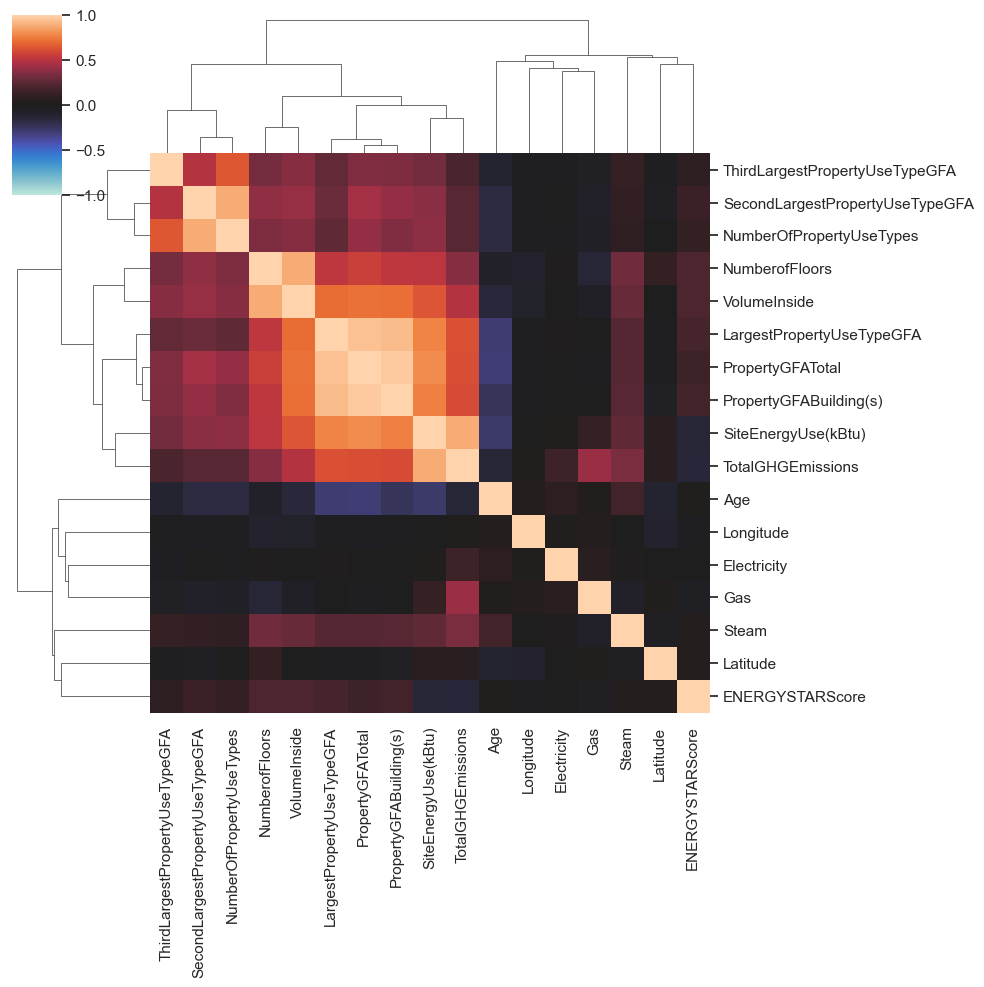

In [76]:
dataTmp = data[[e for e in col_num if not '_' in e]].dropna().corr()
h = sns.clustermap(dataTmp, vmin=-1, vmax=1, center=0)

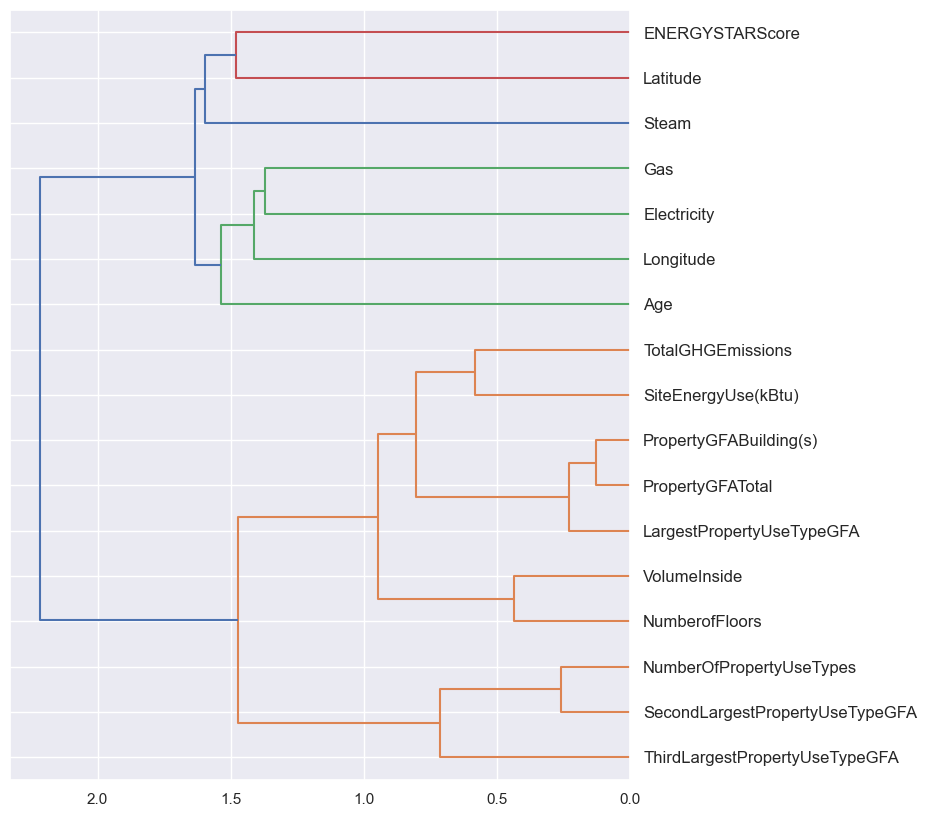

In [77]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=dataTmp.columns, orientation='left');

In [78]:
c = data[col_num].corr().abs()

# c = c[col_Y]

s = c.unstack()
so = s.sort_values(ascending=False)[len(col_num):]
so.head(50)

Type_University                  Type_College/university            0.973003
PropertyGFATotal                 PropertyGFABuilding(s)             0.961193
PropertyGFABuilding(s)           PropertyGFATotal                   0.961193
Type_Residence hall              Type_Residence hall/dormitory      0.954893
Type_Residence hall/dormitory    Type_Residence hall                0.954893
PropertyGFATotal                 LargestPropertyUseTypeGFA          0.909685
LargestPropertyUseTypeGFA        PropertyGFATotal                   0.909685
                                 PropertyGFABuilding(s)             0.896113
PropertyGFABuilding(s)           LargestPropertyUseTypeGFA          0.896113
SiteEnergyUse(kBtu)              TotalGHGEmissions                  0.882342
TotalGHGEmissions                SiteEnergyUse(kBtu)                0.882342
NumberofFloors                   VolumeInside                       0.873529
VolumeInside                     NumberofFloors                     0.873529

In [79]:
so.shape


(2550,)

<AxesSubplot: >

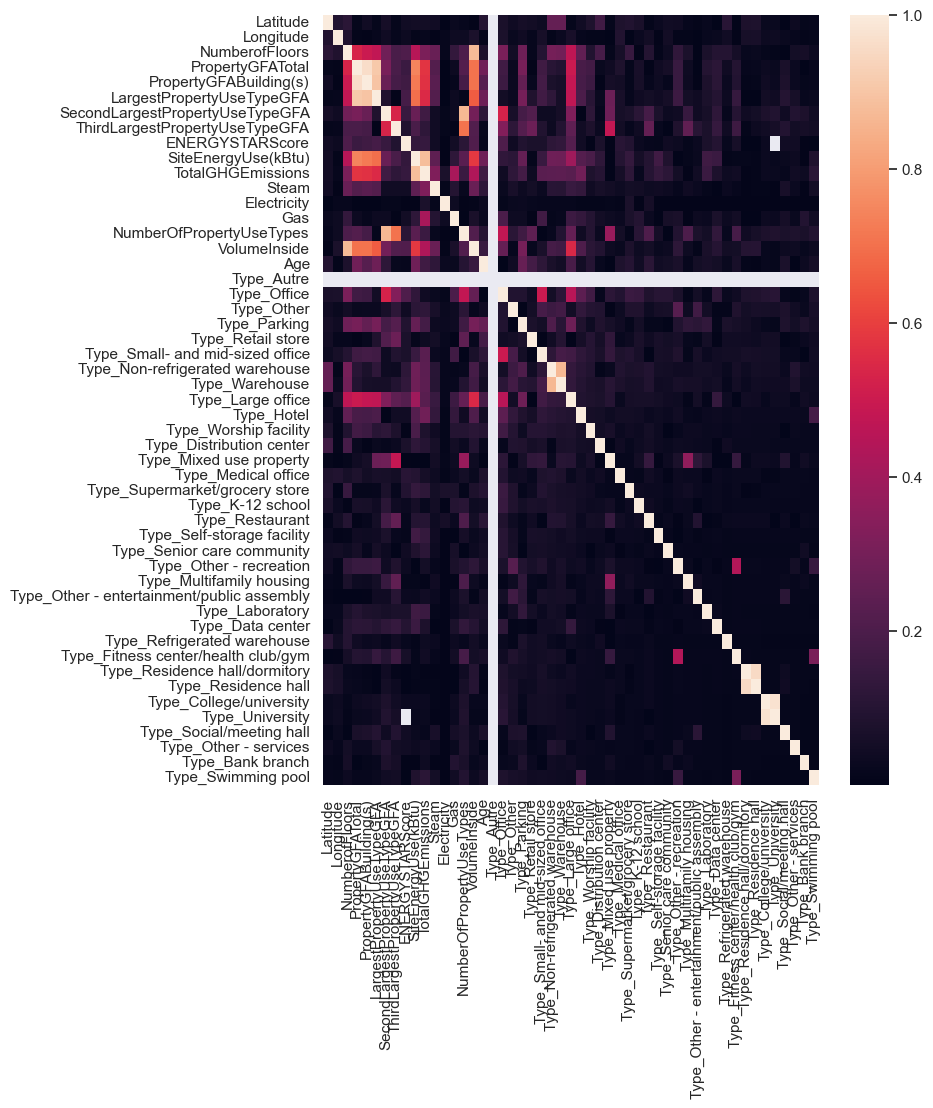

In [80]:
corr = data[col_num].corr().abs()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

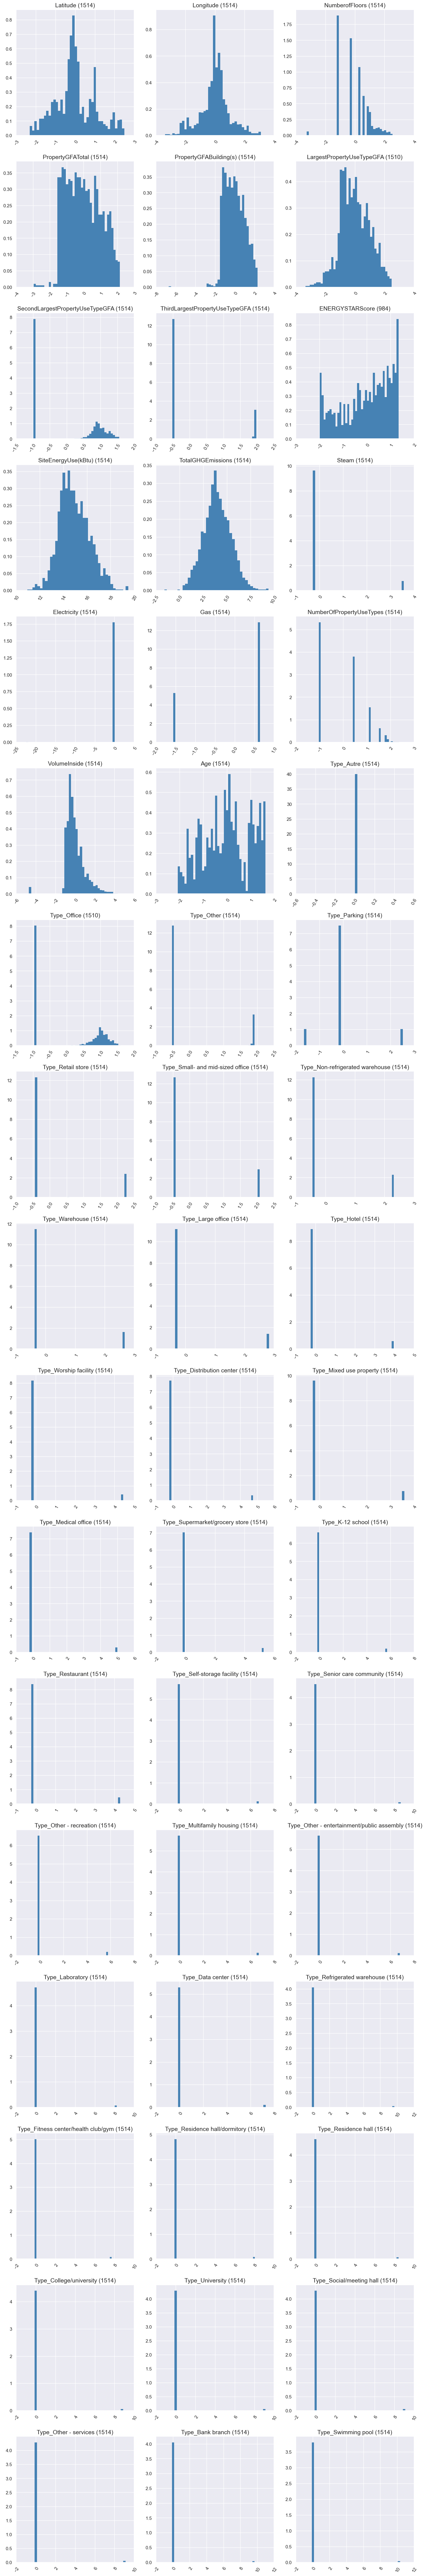

In [81]:
lTmp = list(data[col_autorise].select_dtypes(include=['category', 'int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.hist(tmp, bins=40, color='steelblue', density=True, edgecolor='none')
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    ax.set_xticks(ax.get_xticks(), [x.get_text()[:20] for x in ax.get_xticklabels()], rotation=60, ha='right', rotation_mode='anchor')

fig.tight_layout(pad=1)
plt.show()

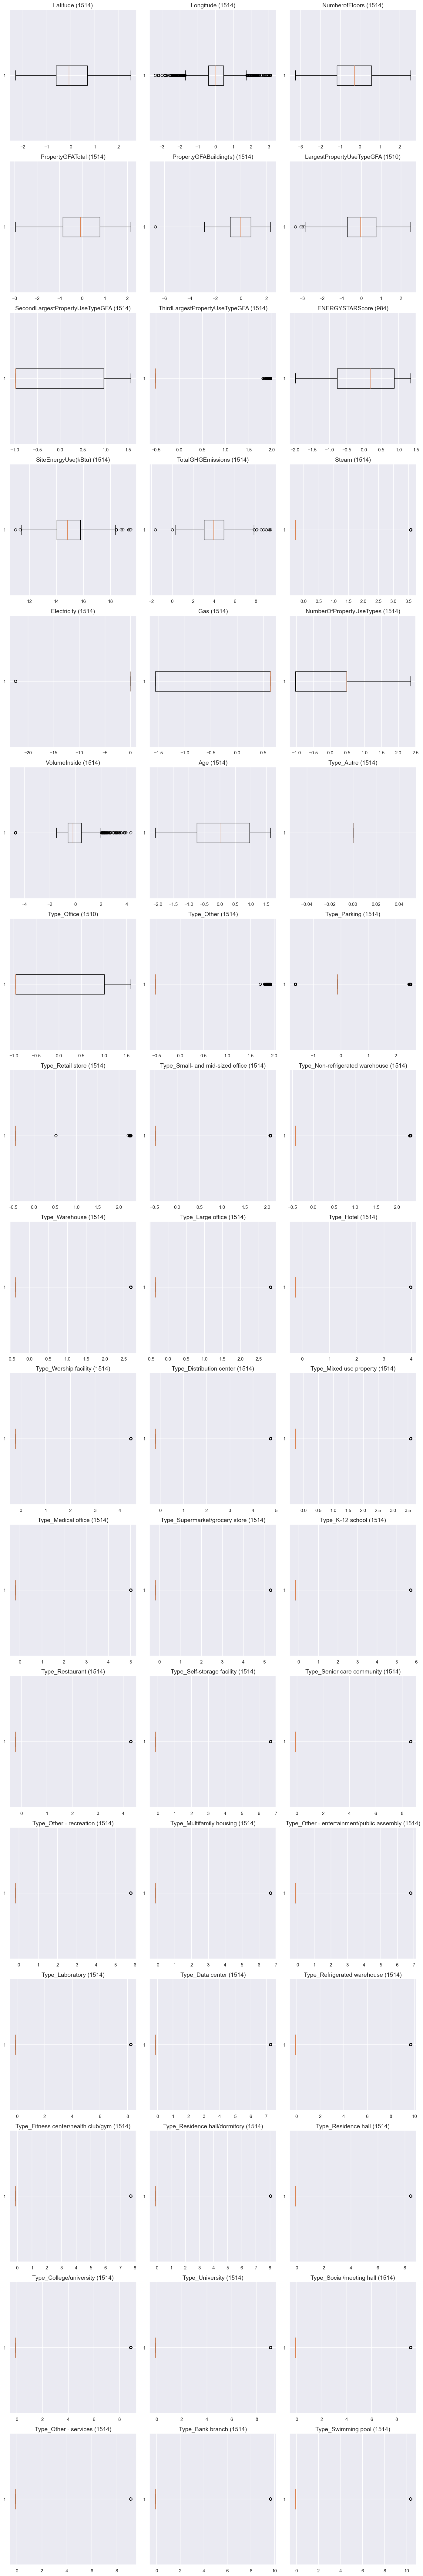

In [82]:
lTmp = list(data[col_autorise].select_dtypes(include=['int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.boxplot(tmp, vert=False)
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    
fig.tight_layout(pad=1)
plt.show()

In [83]:
from math import *
from matplotlib.colors import LogNorm

In [84]:
sns.set(rc={"figure.figsize":(8, 6)})

@interact
def show_articles_more_than(couleur=data.select_dtypes(include=['int', 'float']).columns):
    x = data["Longitude"]
    y = data["Latitude"]

    c = data[couleur]

    fig = plt.figure()
    ax = plt.axes()
    
    if couleur in ['NumberofFloors', 'NumberofBuildings', 'SurfaceInside'] or '(' in couleur:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1, norm=LogNorm())
        ax.scatter(x, y, c=c, s=50, alpha=0.2, norm=LogNorm())
    else:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1)
        ax.scatter(x, y, c=c, s=50, alpha=0.2)
        


    cb = fig.colorbar(sc, ax=ax)
    
    plt.show()

interactive(children=(Dropdown(description='couleur', options=('DataYear', 'BuildingType', 'ZipCode', 'Council…

In [85]:
sns.set(rc={"figure.figsize":(10, 6)})

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[col_num].fillna(0))

In [87]:
pd.DataFrame(X_scaled).describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,...,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00,1514.00
mean,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,...,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.31,-3.38,-3.27,-2.96,-6.70,-3.35,-0.98,-0.51,-2.47,-3.08,...,-0.10,-0.13,-0.12,-0.12,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10
25%,-0.60,-0.40,-1.16,-0.85,-0.83,-0.71,-0.98,-0.51,-0.22,-0.70,...,-0.10,-0.13,-0.12,-0.12,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10
50%,-0.07,0.02,-0.27,-0.08,-0.07,-0.06,-0.98,-0.51,-0.00,-0.10,...,-0.10,-0.13,-0.12,-0.12,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10
75%,0.70,0.46,0.58,0.78,0.77,0.74,0.96,-0.51,0.65,0.66,...,-0.10,-0.13,-0.12,-0.12,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10
max,2.50,3.10,2.56,2.15,2.33,2.49,1.56,1.98,1.67,3.55,...,9.68,7.72,8.05,8.43,8.87,9.12,9.12,9.12,9.68,10.35


In [88]:
n_components = 30

In [89]:
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=30)

In [90]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = col_num
pcs.index = [f"F{i}" for i in range(1, n_components+1)]

In [91]:
(pca.explained_variance_ratio_*100).round(2)

array([12.71,  6.68,  4.84,  4.43,  4.01,  3.87,  3.32,  3.12,  2.74,
        2.69,  2.46,  2.42,  2.35,  2.29,  2.13,  2.09,  2.07,  2.05,
        2.01,  1.97,  1.94,  1.91,  1.89,  1.88,  1.86,  1.81,  1.71,
        1.63,  1.6 ,  1.53])

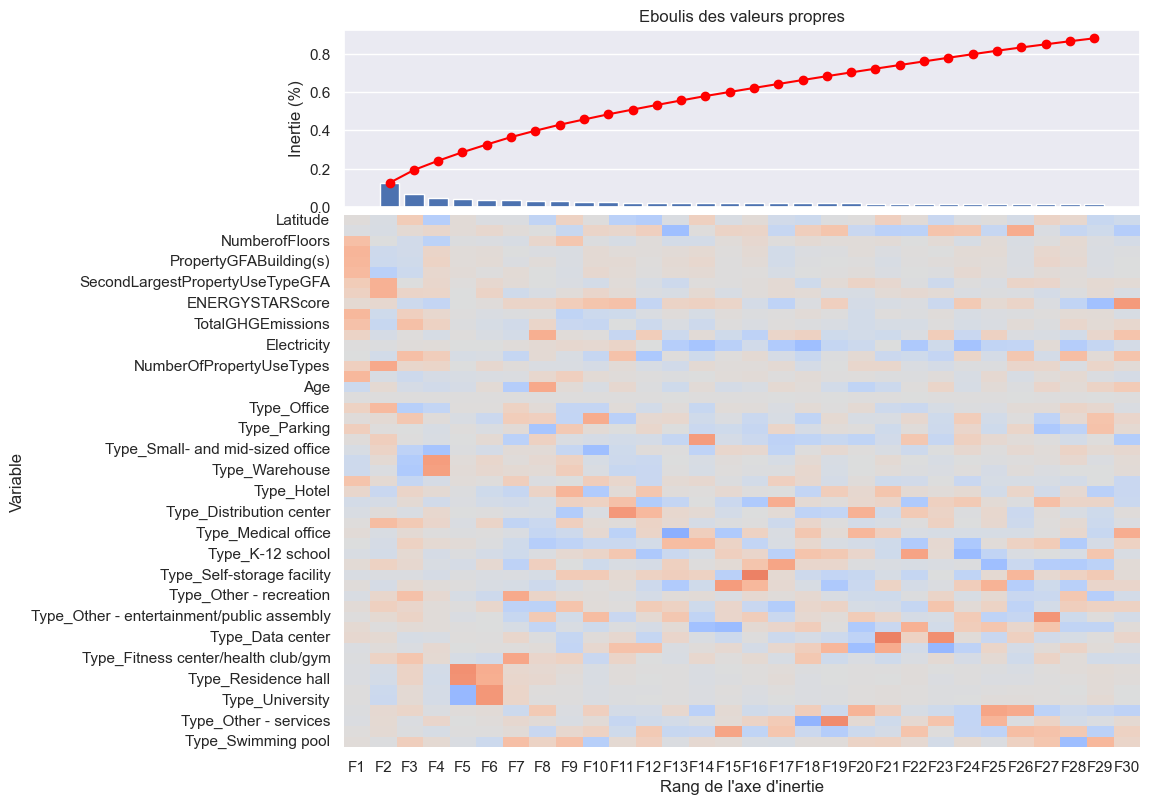

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), gridspec_kw={'height_ratios': [1, 3]})
fig.tight_layout(pad=-1.5)

ax = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=False, cmap="coolwarm", cbar=False, fmt="0.2f", ax=axes[1])

ax.set_xlabel("Rang de l'axe d'inertie")
ax.set_ylabel("Variable")

axes[0].bar(range(1, n_components+1), pca.explained_variance_ratio_)
axes[0].plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(),c="red",marker='o')
axes[0].set_ylabel("Inertie (%)")
axes[0].get_xaxis().set_visible(False)
axes[0].set_title("Eboulis des valeurs propres")

plt.show()

In [93]:
x, y = 0,1
#x, y = 2,3

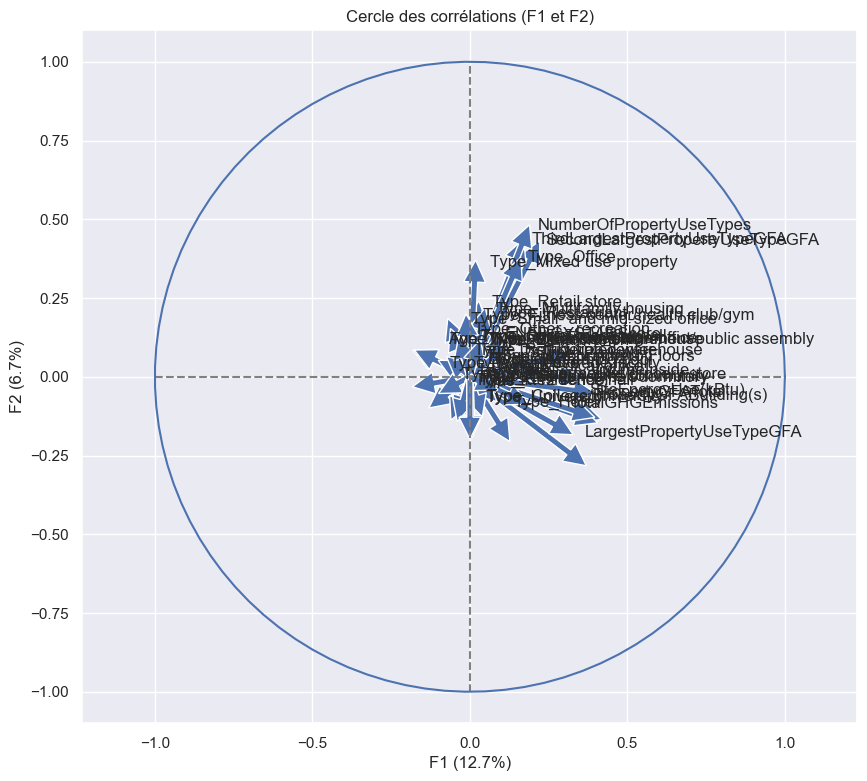

In [94]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[x, i],  #0 for PC1
             pca.components_[y, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             col_num[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)